In [54]:
import warnings
warnings.filterwarnings("ignore")

In [55]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [56]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [57]:
import pandas as pd
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt

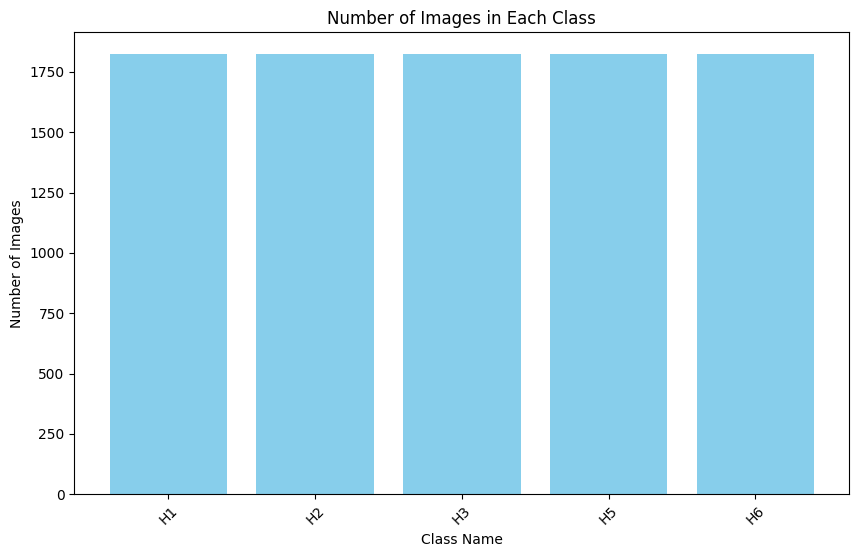

In [58]:
import matplotlib.pyplot as plt

input_folder = "defungi2"

class_names = os.listdir(input_folder)

num_images_per_class = []
for class_name in class_names:
    class_folder = os.path.join(input_folder, class_name)
    num_images = len(os.listdir(class_folder))
    num_images_per_class.append(num_images)

plt.figure(figsize=(10, 6))
plt.bar(class_names, num_images_per_class, color='skyblue')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.xticks(rotation=45)
plt.show()


In [59]:
import os
import shutil
from sklearn.model_selection import train_test_split

input_folder = "defungi"
output_folder = "output"

class_names = os.listdir(input_folder)
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for class_name in class_names:
    class_folder = os.path.join(input_folder, class_name)
    output_train_folder = os.path.join(output_folder, "train", class_name)
    output_test_folder = os.path.join(output_folder, "test", class_name)
    os.makedirs(output_train_folder, exist_ok=True)
    os.makedirs(output_test_folder, exist_ok=True)

    images = os.listdir(class_folder)
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    for image in train_images:
        src = os.path.join(class_folder, image)
        dest = os.path.join(output_train_folder, image)
        shutil.copy(src, dest)

    for image in test_images:
        src = os.path.join(class_folder, image)
        dest = os.path.join(output_test_folder, image)
        shutil.copy(src, dest)
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'output/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=256,
    image_size=(224, 224),
    seed=42
)

class_names = train_dataset.class_names
class_names

Found 7290 files belonging to 5 classes.


['H1', 'H2', 'H3', 'H5', 'H6']

In [60]:
image_size = 224

data_generator_with_aug = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    vertical_flip=True,
)

data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator_with_aug.flow_from_directory(
        'output/train',
        target_size=(image_size, image_size),
        batch_size=256,
        class_mode='categorical',
        shuffle=False)

validation_generator = data_generator_no_aug.flow_from_directory(
        'output/test',
        target_size=(image_size, image_size),
        batch_size=256,
        class_mode='categorical',
        shuffle=False)

Found 7290 images belonging to 5 classes.
Found 1824 images belonging to 5 classes.


In [44]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model

# Load InceptionV3 base model
inception_base = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Add custom classification head
x = inception_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(32)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)

# Define model
model = Model(inputs=inception_base.input, outputs=output)

# Freeze pre-trained layers
for layer in inception_base.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0015),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [45]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy',patience=8)

In [46]:
model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=80,
    verbose=1,
    callbacks = [early_stopping]
)

Epoch 1/80
29/29 [==============================] - 204s 7s/step - loss: 1.5341 - accuracy: 0.4224 - val_loss: 5.3290 - val_accuracy: 0.1217
Epoch 2/80
29/29 [==============================] - 176s 6s/step - loss: 1.2409 - accuracy: 0.5243 - val_loss: 2.1786 - val_accuracy: 0.2325
Epoch 3/80
29/29 [==============================] - 175s 6s/step - loss: 1.1492 - accuracy: 0.5388 - val_loss: 1.5792 - val_accuracy: 0.3613
Epoch 4/80
29/29 [==============================] - 178s 6s/step - loss: 1.1057 - accuracy: 0.5501 - val_loss: 1.2233 - val_accuracy: 0.4677
Epoch 5/80
29/29 [==============================] - 174s 6s/step - loss: 1.0738 - accuracy: 0.5712 - val_loss: 1.1864 - val_accuracy: 0.4984
Epoch 6/80
29/29 [==============================] - 173s 6s/step - loss: 1.0431 - accuracy: 0.5790 - val_loss: 1.0360 - val_accuracy: 0.5888
Epoch 7/80
29/29 [==============================] - 173s 6s/step - loss: 1.0317 - accuracy: 0.5849 - val_loss: 0.9910 - val_accuracy: 0.6031
Epoch 8/80
29

In [47]:
hist = model.history

# Print model summary
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_282 (Batch  (None, 111, 111, 32  96         ['conv2d_282[0][0]']             
 Normalization)                 )                                                           

In [48]:
hist = hist.history

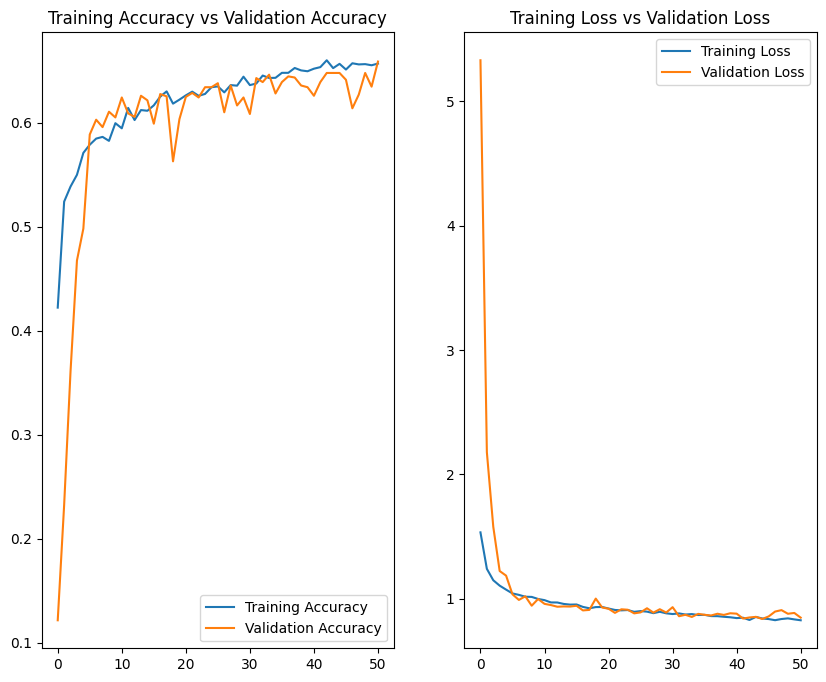

In [50]:
acc=hist['accuracy']
val_acc=hist['val_accuracy']

loss=hist['loss']
val_loss=hist['val_loss']

plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.plot(range(51),acc,label='Training Accuracy')
plt.plot(range(51),val_acc,label='Validation Accuracy')
plt.legend()
plt.title("Training Accuracy vs Validation Accuracy")


plt.subplot(1,2,2)
plt.plot(range(51),loss,label='Training Loss')
plt.plot(range(51),val_loss,label='Validation Loss')
plt.title("Training Loss vs Validation Loss")
plt.legend()
plt.show()

In [52]:
model.save("models/v34.h5")

In [61]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import tensorflow as tf

model = tf.keras.models.load_model("models/v34.h5")

test_loss, test_accuracy = model.evaluate(validation_generator, verbose=1)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


8/8 [==============================] - 40s 4s/step - loss: 0.8485 - accuracy: 0.6590
Test Loss: 0.8484503030776978
Test Accuracy: 0.6589912176132202


In [62]:
from sklearn.metrics import precision_recall_fscore_support

predicted_probabilities = model.predict(validation_generator, verbose=1)

true_labels = []
for x, y in validation_generator:
    true_labels.extend(np.argmax(y, axis=1))
    if len(true_labels) >= len(predicted_probabilities):
        break

predicted_labels = np.argmax(predicted_probabilities, axis=1)

precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)


8/8 [==============================] - 37s 4s/step
Precision: 0.6425932848415478
Recall: 0.6589912280701754
F1-score: 0.6320010134650429


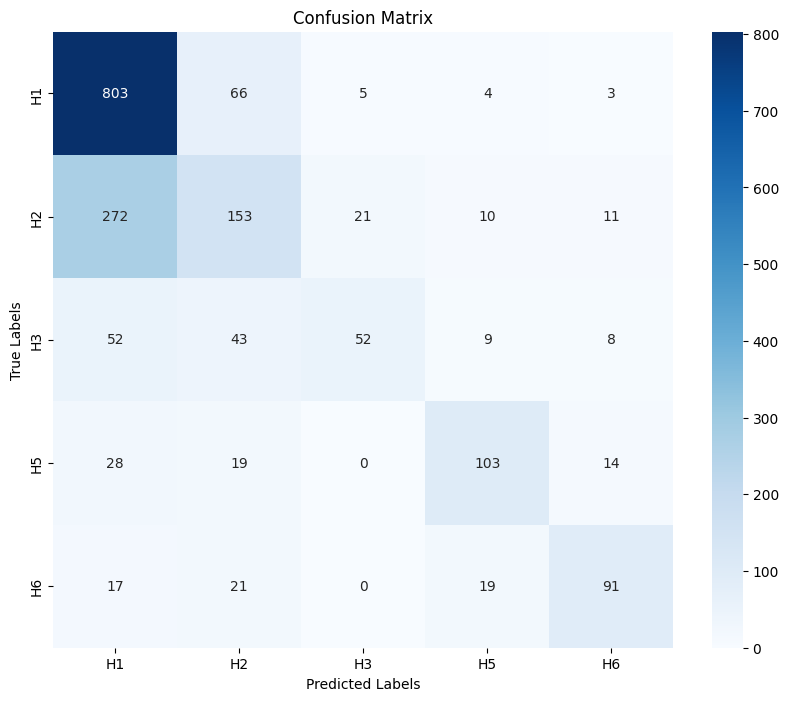

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array = preprocess_input(img_array)
    return img_array

def predict_images(model, image_paths, class_names):
    predictions = []
    for img_path in image_paths:
        img_array = load_and_preprocess_image(img_path)
        pred_probs = model.predict(img_array)
        predicted_class_index = np.argmax(pred_probs)
        predicted_class = class_names[predicted_class_index]
        predictions.append(predicted_class)
    return predictions

image_paths = ["defungi/H6/H6_2a_15.jpg","defungi/H2/H2_1a_1.jpg","defungi/H3/H3_1b_1.jpg","defungi/H5/H5_1a_1.jpg","defungi/H3/H3_2a_10.jpg"]
predicted_classes = predict_images(model, image_paths, class_names)
for i, predicted_class in enumerate(predicted_classes):
    print(f"Image {i+1} Predicted Class:", predicted_class)



1/1 [==============================] - 0s 49ms/step
Image 1 Predicted Class: H1
Image 2 Predicted Class: H1
Image 3 Predicted Class: H1
Image 4 Predicted Class: H1
Image 5 Predicted Class: H2
